### 유방암 데이터 분석

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# 데이터 확인 및 전처리

In [2]:
df_raw = pd.read_csv("rawdata/IRIS.csv")
df_raw.head()

,SEPAL_LENGTH,SEPAL_WIDTH,PETAL_LENGTH,PETAL_WIDTH,SPECIES
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


# 결측치 검측

In [3]:
df_raw.isnull().sum()

SEPAL_LENGTH    0
SEPAL_WIDTH     0
PETAL_LENGTH    0
PETAL_WIDTH     0
SPECIES         0
dtype: int64

# 범주형 변수 확인

In [4]:
obj_cols = df_raw.select_dtypes("object").columns
for col in obj_cols:
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

SPECIES : 3


# 더미 변수 생성

# 트레인 세트와 테스트 세트 + 검증 세트 구분

In [6]:
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 1234)
print("Train data size\t: {}".format(df_train.shape))
print("Test data size\t: {}".format(df_test.shape))

Train data size	: (105, 5)
Test data size	: (45, 5)


# 세트들을 종속변수 (y) 와 독립변수 (x) 로 구분

In [7]:
df_train_x = df_train.drop(["SPECIES"], axis = 1)
df_train_y = df_train[["SPECIES"]]
df_test_x = df_test.drop(["SPECIES"], axis = 1)
df_test_y = df_test[["SPECIES"]]

# 2) 모델생성

# 최종 모델 선정

In [14]:
tree_final = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 5,  criterion='entropy')
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

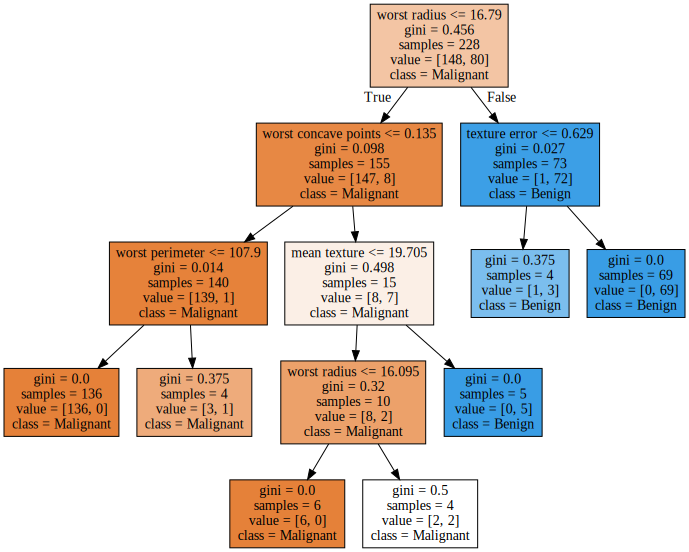

In [107]:
export_graphviz(tree_final, out_file = "tree_final.dot", class_names =["Malignant", "Benign"],
                feature_names = v_feature_name, impurity = True, filled = True) 

with open("tree_final.dot") as f:
    dot_graph = f.read()
    
display(graphviz.Source(dot_graph))

In [15]:
y_pred = tree_final.predict(df_test_x)
print("Test set accuracy: %.3f" % tree_final.score(df_test_x, df_test_y))
cfm = confusion_matrix(df_test_y, y_pred)
print("Confusion matirx\n{}".format(cfm))


Test set accuracy: 0.956
Confusion matirx
[[16  0  0]
 [ 0 16  1]
 [ 0  1 11]]


In [109]:
df_importance = pd.DataFrame()
df_importance["feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,feature,Importance
20,worst radius,0.889
27,worst concave points,0.058
1,mean texture,0.043
22,worst perimeter,0.005
11,texture error,0.005
0,mean radius,0.000
16,concavity error,0.000
28,worst symmetry,0.000
26,worst concavity,0.000
25,worst compactness,0.000


Text(0, 0.5, '설명번수')

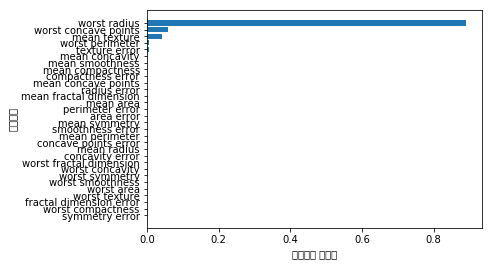

In [113]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명번수")

# GridSearchCV로 최적 파라미터 찾기

In [102]:
estimator = DecisionTreeClassifier()
param_grid = {"max_depth": para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}

grid_df = GridSearchCV(estimator, param_grid, scoring = "accuracy", n_jobs = -1)
grid_df.fit(df_train_x, df_train_y)

print("Best estimator model: \n{}".format(grid_df.best_estimator_))
print("\nBest parameter: \n{}".format(grid_df.best_params_))
print("\nBest Score: {}".format(grid_df.best_score_.round(3)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best estimator model: 
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Best parameter: 
{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 10}

Best Score: 0.934


In [105]:
tree_final = DecisionTreeClassifier(max_depth = 2, min_samples_split = 10, min_samples_leaf = 2, random_state = 42)
tree_final.fit(df_train_x, df_train_y)

y_pred = tree_final.predict(df_test_x)
print("Test set accuracy: %.3f" % tree_final.score(df_test_x, df_test_y))
y_pred = tree_final.predict(df_valid_x)
print("Valid set accuracy: %.3f" % tree_final.score(df_valid_x, df_valid_y))


Test set accuracy: 0.889
Valid set accuracy: 0.894


# 해석

트리 분리에 영향을 미치는 변수: 
- worst radius
- concave point
- texture error